Используем Датасет adult_income для нахождения зависимостей между доходом человека и его характеристиками. Такая Задача может быть полезна банкам для Анализа клиентов.

In [4]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from matplotlib.colors import ListedColormap
from datetime import datetime 
from pandas import Series, DataFrame 
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

%matplotlib inline

RANDOM_STATE = 42

# Функции для работы с данными


In [5]:
def memory_analyse(df):
    for dtype in ['float','int','object']:
        selected_dtype = df.select_dtypes(include=[dtype])
        mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
        mean_usage_mb = mean_usage_b / 1024 ** 2
        print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

def show_data(df):
    for col in df.columns:
        print("{0}: {1}".format(col, df[col].unique()))
    print(df.columns)
    

def make_submission(ids, pred, output_path='submission.csv'):
    subm = pd.DataFrame()
    subm['id'] = ids
    subm['income'] = pred
    subm.to_csv(output_path, index=False) 

def corr(df):
    s1 = pd.Series(df["income"])
    for col in df.columns:
        if (col != "date"):
            s2 = pd.Series(df[col])
            c = s1.corr(s2 )
            print("corr {0} with price: {1}".format(col, c))
            
def make_NaN(df):
    for col in df.columns:
        df[col][df[col] == ' ?'] = None
            
def find_NaN(df):
    nans = df.loc[:, df.isnull().any()].copy()
    print(nans.columns)
    nans = nans.isna().sum()
    print(nans)

# Анализ

In [6]:
pd.set_option('display.max_columns', 100)

Смотрим все ли правильно загрузилось

In [8]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
train.shape

(32561, 15)

Типы каждого из признаков, видим проблему, что многие признаки имеют тип объект

In [10]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [12]:
train.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [20]:
train.describe(include=['object'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


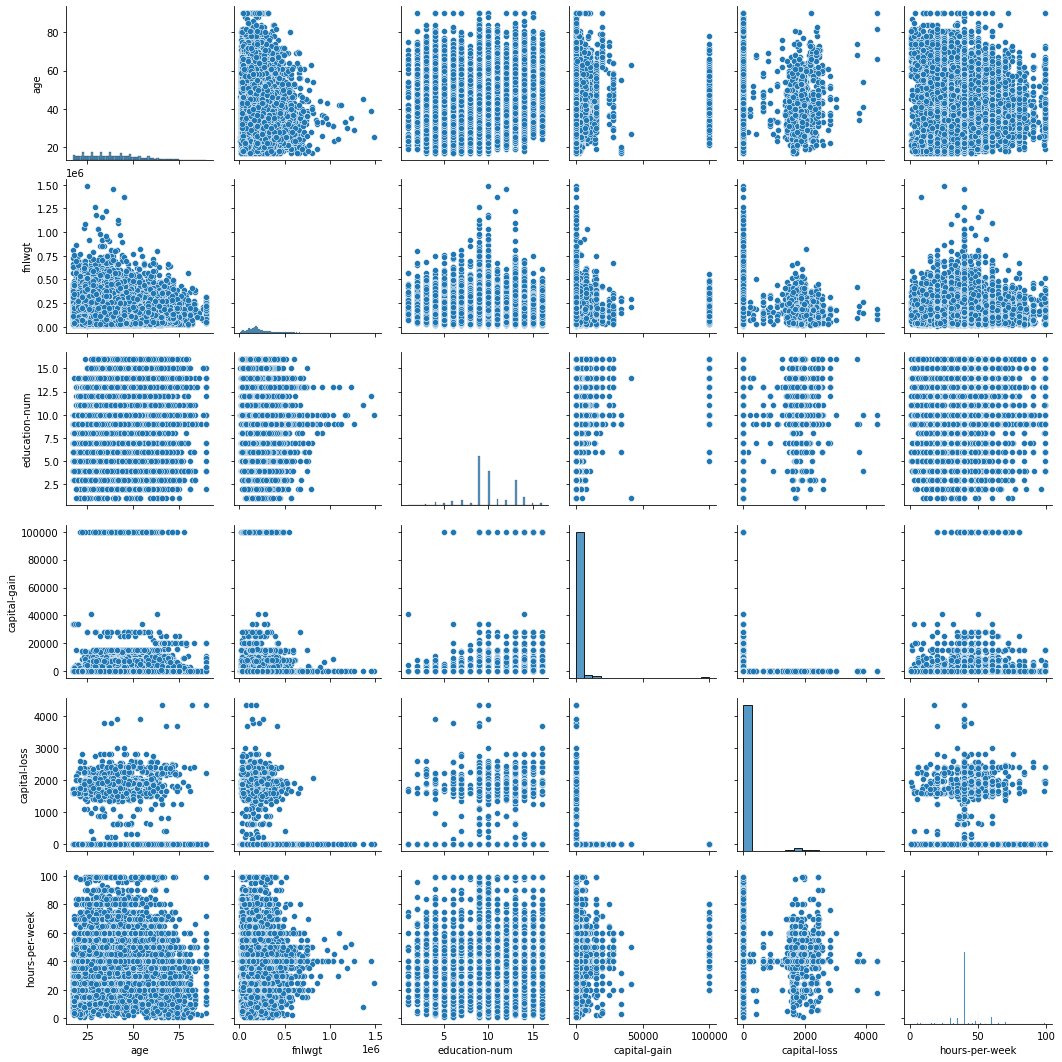

In [25]:
cols = ['age', 'fnlwgt',  'education-num',
       'capital-gain', 'capital-loss','hours-per-week']
sns_plot = sns.pairplot(train[cols].dropna())

Посмотрим на корреляции

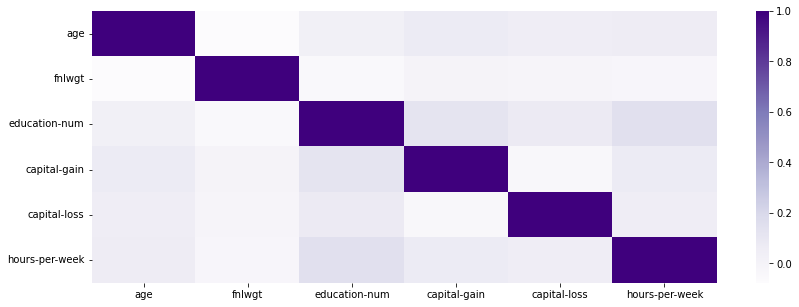

In [26]:
fig = plt.figure(figsize= (14,5))
sns.heatmap(train[cols].dropna().corr(), cmap = 'Purples')

Уникальные значения в каждом из признаков

In [32]:
unique_counts = pd.DataFrame.from_records([(col, train[col].dtype, train[col].nunique()) for col in train.columns],
                          columns=['Column_Name', 'Type', 'Num_Unique']).sort_values(by=['Num_Unique'])
unique_counts

,Column_Name,Type,Num_Unique
9,sex,object,2
14,income,object,2
8,race,object,5
7,relationship,object,6
5,marital-status,object,7
1,workclass,object,9
6,occupation,object,15
3,education,object,16
4,education-num,int32,16
13,native-country,object,42


Распределение данных в каждом из признаков

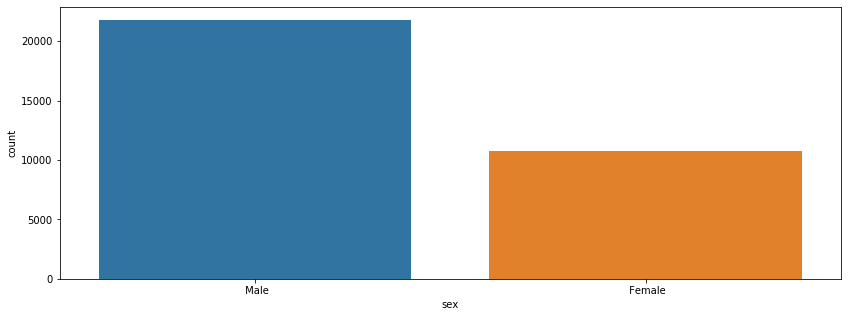

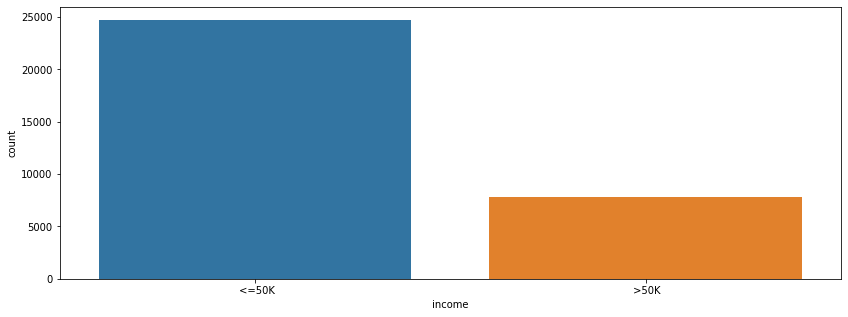

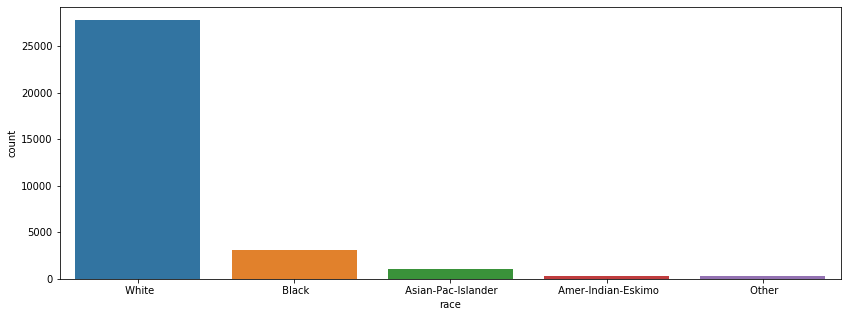

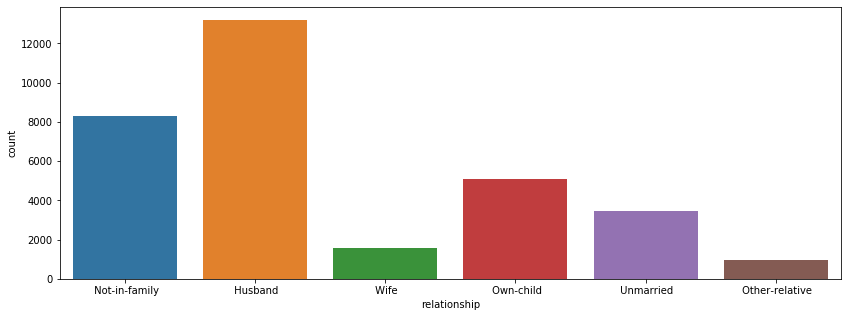

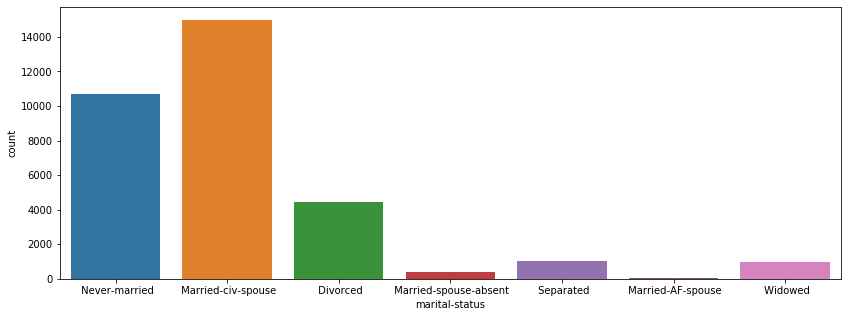

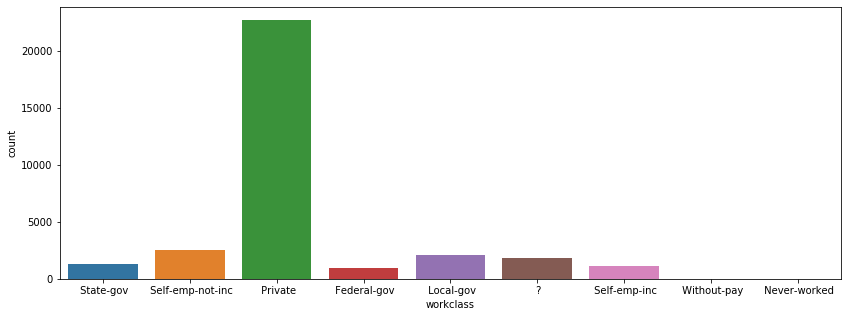

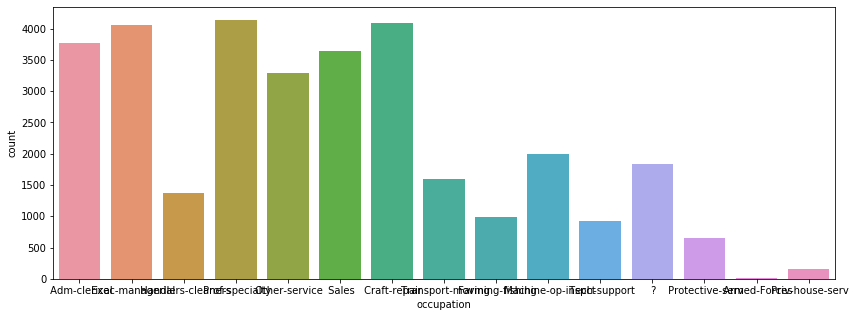

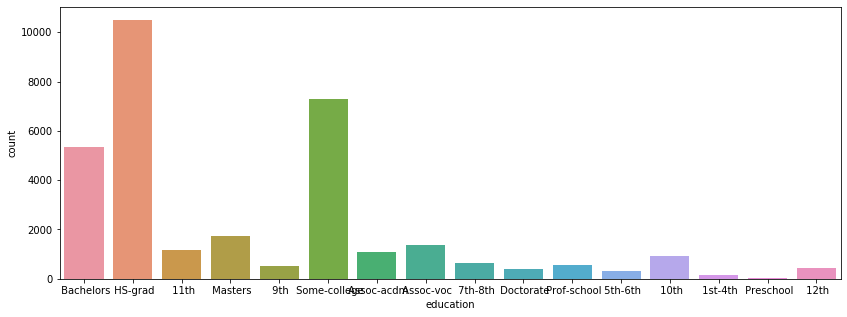

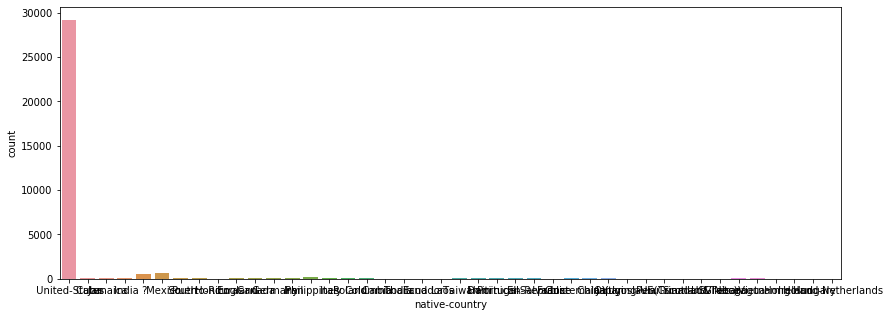

In [ ]:
cols = ['sex', 'income',  'race',
       'relationship', 'marital-status','workclass', 'occupation', 'education', 'native-country']
for c in cols:    
    fig = plt.figure(figsize= (14,5))
    sns.countplot(train[c])
  

Преобразуем колонку income, распределяем доходы на больше 50к в год и меньше

In [33]:
train.income.replace([' >50K', ' <=50K'], [1, 0], inplace=True) 
test.income.replace([' >50K.', ' <=50K.'], [1, 0], inplace=True)

train['income'] = train['income'].astype('int32')
test['income'] = test['income'].astype('int32')

Заполняем пропущенные значения NaN

In [ ]:
make_NaN(train)
make_NaN(test)

Графически видим, что существует зависимость между возрастом и доходом

<Figure size 2880x2880 with 0 Axes>

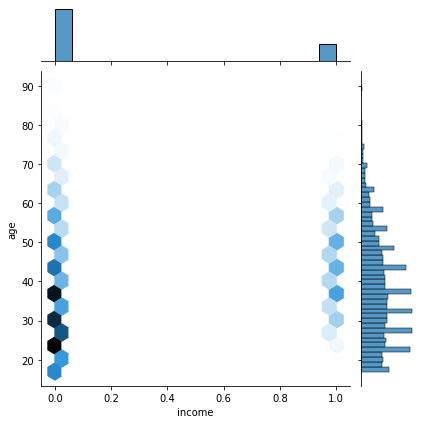

In [38]:
# ДОСТАТОК-ВОЗРАСТ
fig = plt.figure(figsize=(40, 40))
sns.jointplot(x='income', y='age', data=train, kind ='hex',gridsize=20)

Посмотрим на зависимость между доходом и номер обучения.

Видим, что люди с большим доходом имеют большой заработок (12-16)

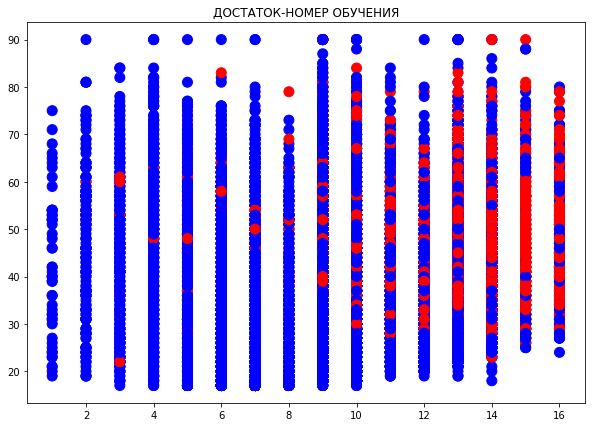

In [39]:
# ДОСТАТОК-НОМЕР ОБУЧЕНИЯ-ВОЗРАСТ
colors = ListedColormap(["blue", "red"])
# 0 - blue
# 1 - red
plt.figure(figsize=(10,7))
plt.title("ДОСТАТОК-НОМЕР ОБУЧЕНИЯ")
plt.scatter(train['education-num'], train['age'], c=train['income'], cmap=colors, s=100)
plt.show()

График зависимости заработка от количества часов в неделю.

Видим, что набиольший зарабаток у людей, которые работают 40-60 часов в неделю

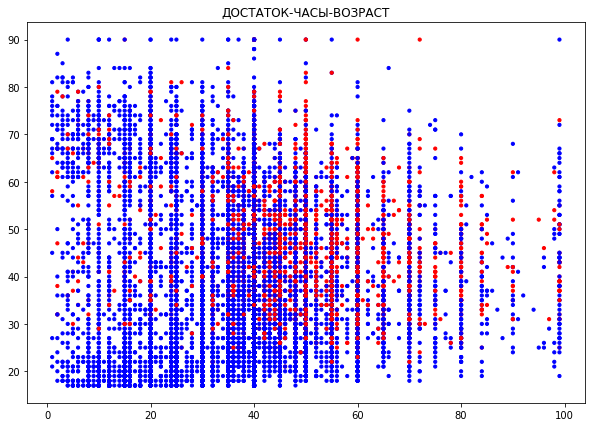

In [40]:
# ДОСТАТОК-ЧАСЫ-ВОЗРАСТ
colors = ListedColormap(["blue", "red"])
plt.figure(figsize=(10,7))
plt.title("ДОСТАТОК-ЧАСЫ-ВОЗРАСТ")
plt.scatter(train['hours-per-week'], train['age'], c=train['income'], cmap=colors, s=10)
plt.show()

Посмотрим зависмость заработка от пола.

Видим, что мужчины зарабатывают больше, чем женщины

<BarContainer object of 4 artists>

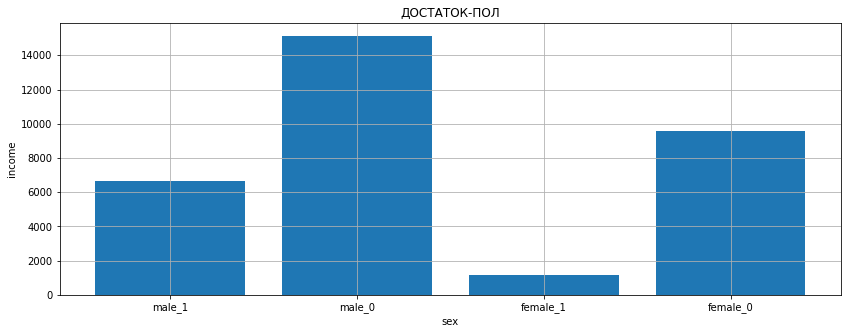

In [41]:
# ДОСТАТОК-ПОЛ
sex = ['male_1','male_0', 'female_1', 'female_0']

male_1 = train[train.sex == ' Male'][['income']].income.sum()
male_0 = train[(train.sex == ' Male') & (train.income == 0)][['sex']].count()
female_1 = train[train.sex == ' Female'][['income']].income.sum()
female_0 = train[(train.sex == ' Female') & (train.income == 0)][['sex']].count()

cls = [male_1, male_0, female_1, female_0]

fig = plt.figure(figsize=(14,5))
ax1 = fig.add_subplot()
ax1.set_xlabel('sex')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-ПОЛ')
ax1.grid()
ax1.bar(sex, cls) 

Посмортим теперь зависимость дохода от вида образования.

Видим, что существует сильная зависимость от вида образования.

Хотя, можно считать, что большинство людей обучались в общественной школе и поэтому такое распредление.

<BarContainer object of 16 artists>

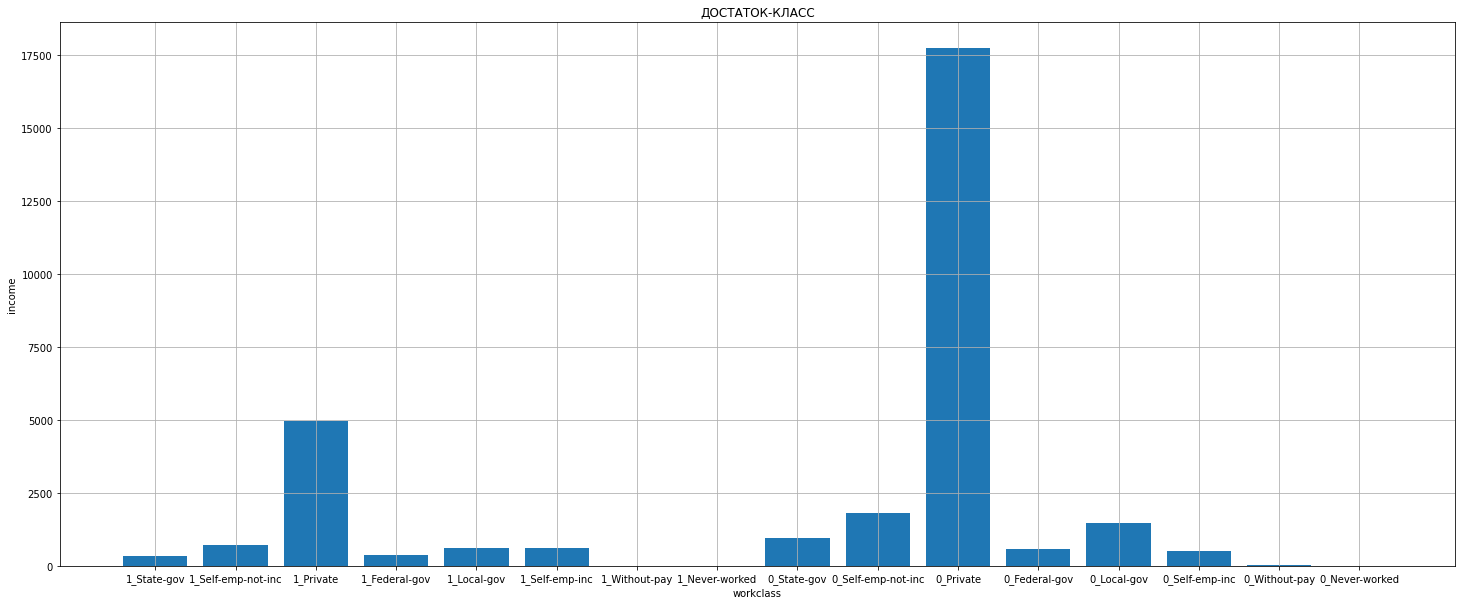

In [36]:

cls = ['1_State-gov', '1_Self-emp-not-inc', '1_Private', '1_Federal-gov', '1_Local-gov',
 '1_Self-emp-inc', '1_Without-pay', '1_Never-worked', '0_State-gov', '0_Self-emp-not-inc', '0_Private', '0_Federal-gov', '0_Local-gov',
 '0_Self-emp-inc', '0_Without-pay', '0_Never-worked']
 
cols = [' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov', ' Local-gov', ' Self-emp-inc', ' Without-pay', ' Never-worked']

cls_1 = []
cls_0 = []

for col in cols:
    cls_1.append(train[train.workclass == col][['income']].income.sum())
    cls_0.append(train[(train.workclass == col) & (train.income == 0)][['workclass']].workclass.count())

clss = cls_1 + cls_0

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('workclass')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-КЛАСС')
ax1.grid()
ax1.bar(cls, clss) 

<BarContainer object of 16 artists>

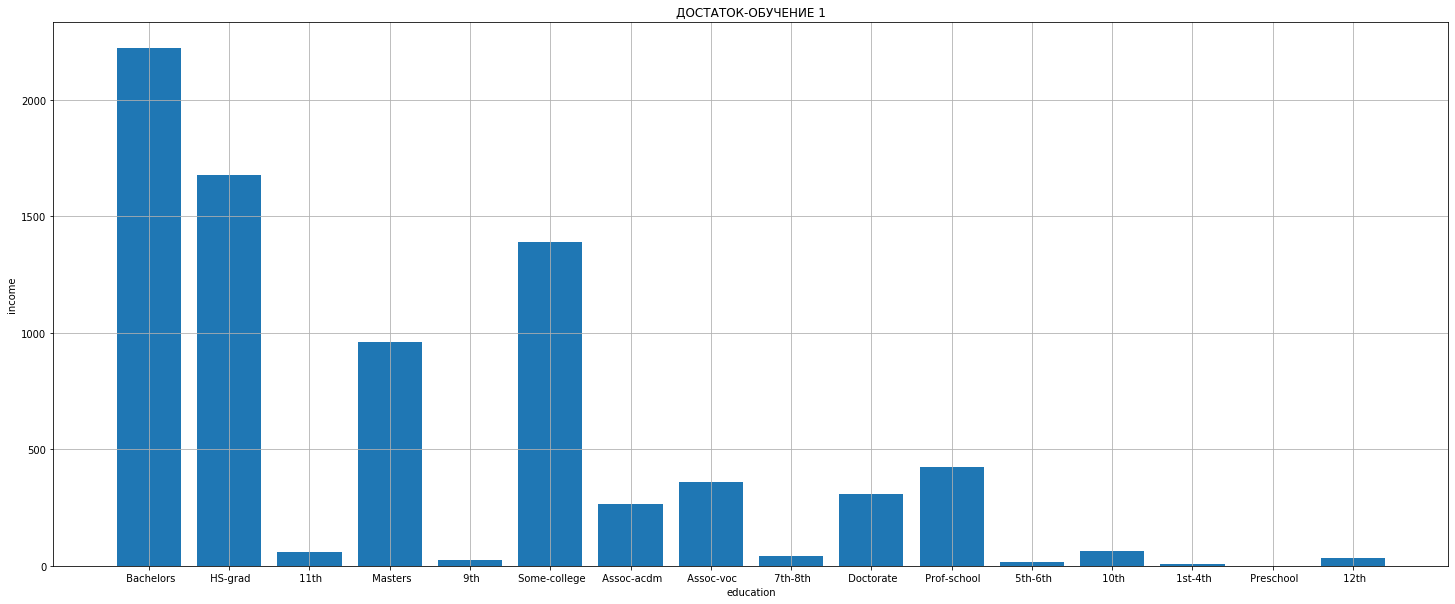

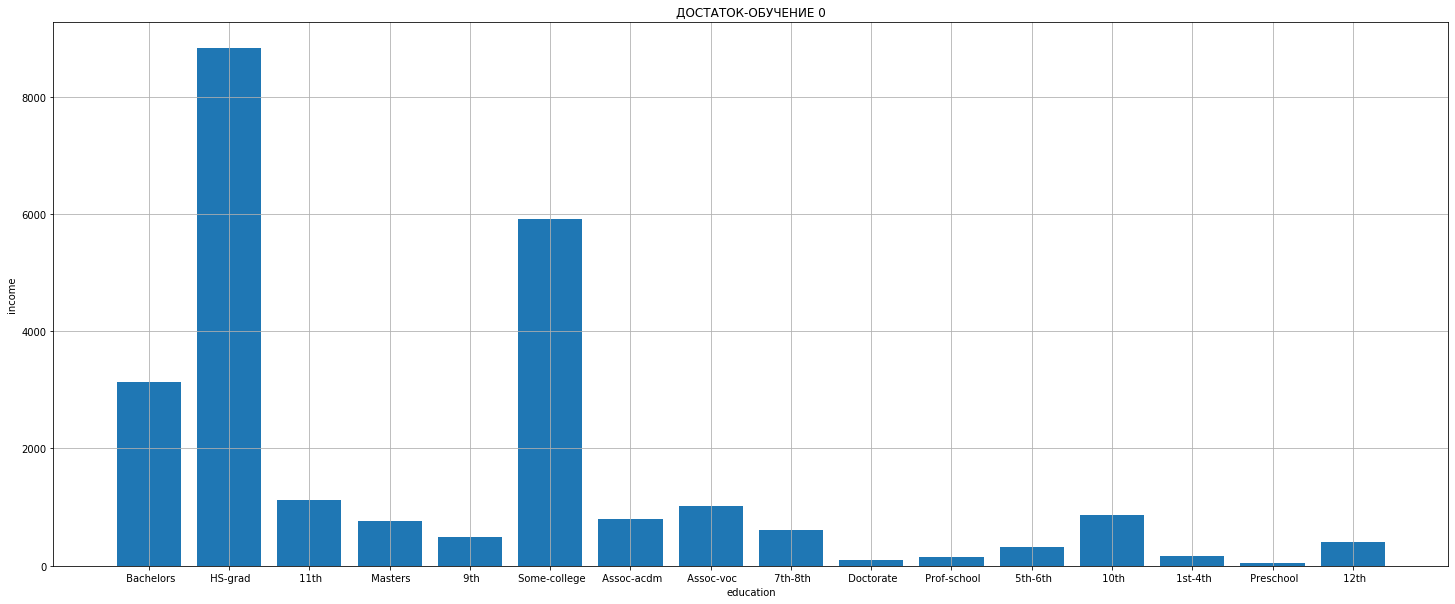

In [ ]:
# ДОСТАТОК-ОБУЧЕНИЕ

cls = [' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th', ' Some-college',
 ' Assoc-acdm', ' Assoc-voc', ' 7th-8th', ' Doctorate', ' Prof-school',
 ' 5th-6th', ' 10th', ' 1st-4th', ' Preschool', ' 12th']

cls_1 = []
cls_0 = []

for col in cls:
    cls_1.append(train[train.education == col][['income']].income.sum())
    cls_0.append(train[(train.education == col) & (train.income == 0)][['education']].education.count())

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('education')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-ОБУЧЕНИЕ 1')
ax1.grid()
ax1.bar(cls, cls_1) 

fig = plt.figure(figsize= (25,10))
ax1 = fig.add_subplot()
ax1.set_xlabel('education')
ax1.set_ylabel('income')
ax1.set_title('ДОСТАТОК-ОБУЧЕНИЕ 0')
ax1.grid()
ax1.bar(cls, cls_0) 

Посмотрим на корреляцию между выделенным признаками и выберем основные коррелирующие признаки.

Видим, что income плохо коррелирует с fnlwgt, поэтому его исключим из дальнеейшего рассмотрения.

In [ ]:
train.corr()
# age, education-num, capital-gain, capital-loss, hours-per-week

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
income,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


Мы выделили основные признаки для рассмотрения данной задачи.

Осталоьс только обучить модель.